In [2]:
%%capture

! pip install git+https://github.com/djpasseyjr/interfere@3e62534c294776c620dd57994a4b3ee864bd3c12
! pip install git+https://github.com/djpasseyjr/interfere_experiments.git@4f9f292913d8e4e8b42c35ea0ef5de8dad02994c

In [135]:
import pickle

from collections import OrderedDict
import io
from typing import Any, Optional, Union

import graphviz
import interfere
import interfere.methods
import interfere_experiments as ie
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import optuna
from scipy.interpolate import CubicSpline
import sympy

RNG = np.random.default_rng(11)
OPTUNA_TRIALS = 2
N_OBS_LIST = [105]#, 500, 1000, 1500, 2000]
METHODS = [
    #interfere.methods.NHITS,
    interfere.methods.SINDY,
    interfere.methods.ResComp,
    #interfere.methods.LSTM,
]
SAVE_FILE = "confound_exp_gpu.pkl"
RESULTS = {}
COLORS = ["green", "orange", "purple", "cyan"]


MULTI_CONF_ADJ = np.array([
    [0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0],
])

DOWNSTREAM_ADJ = np.array([
    [0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.0],
])

TRAIN_STEPS = 10_000
FORECAST_STEPS = 1000
MAX_NUM_STEPS = TRAIN_STEPS + FORECAST_STEPS + 100
DIM = 4
NODE_LABEL_LISTS = [
    ["1 T", "2 Y", "3 H", "4 H"],
    ["1 T", "2 Y", "3 V", "4 H"],
    ["1 T", "2 Y", "3 V", "4 V"],
]

In [93]:
# @title Random Signal and Graph Vis
def uniform_frequency_dist_random_signal(
    total_time: float,
    amplitude_min: float = 0.0,
    amplitude_max: float = 1.0,
    frequency_min: float = 2.0,
    frequency_max: float = 10.0,
    rng: Optional[np.random.RandomState] = None,
) -> np.ndarray:
    """Creates a signal with a uniform dist of frequencies and amplitudes.

    Args:
        total_time (float): Total time in seconds.
        amplitude_min (float): Minimum amplitude.
        amplitude_max (float): Maximum amplitude.
        frequency_min (float): Minimum frequency in oscillations per second.
            Must be greater than zero.
        frequency_max (float): Maximum frequency in oscillations per second.
            Must be greater than frequency_min.
        rng (np.random.RandomState): Random number generator.

    Returns:
        times (np.ndarray): Time values for a signal with a uniform dist of
            frequencies and amplitudes.
        values (np.ndarray): Values for a signal with a uniform dist of
            frequencies and amplitudes.
    """
    if total_time <= 0:
        raise ValueError("total_time must be greater than 0")

    if 1/frequency_min >= total_time:
        raise ValueError("1/frequency_min must be less than total_time")

    if frequency_max < frequency_min:
        raise ValueError("frequency_max must be greater than frequency_min")

    if amplitude_max <= amplitude_min:
        raise ValueError("amplitude_max must be greater than amplitude_min")

    if rng is None:
        rng = np.random.default_rng()

    rand_val = lambda : rng.random() * (
        amplitude_max - amplitude_min) + amplitude_min
    rand_freq = lambda : rng.random() * (
        frequency_max - frequency_min) + frequency_min

    times = [0]
    values = [rand_val()]
    while times[-1] < total_time:
        times.append(times[-1] + 1/rand_freq())
        values.append(rand_val())

    return np.array(times), np.array(values)

def randsig(max_T, amin=-1, amax=1, fmin=2, fmax=10, rng=RNG):
    return CubicSpline(
        *uniform_frequency_dist_random_signal(
            max_T, amplitude_min=amin, amplitude_max=amax,
            frequency_min=fmin, frequency_max=fmax, rng=rng
        ),
        bc_type="clamped", extrapolate=False,
    )

In [137]:
# @title Convergnce Experiment Functions
def remove_unmeasured(
    interv: interfere.ExogIntervention,
    num_measured_states: int
):
    """Removes exogenous variables which are not measured.
    """
    measured_idx = [
        idx for idx in interv.intervened_idxs
        if idx < num_measured_states
    ]

    if not measured_idx:
        return interfere.IdentityIntervention()

    if isinstance(interv, interfere.SignalIntervention):
        signals = [
            interv.signals[i] for i, idx in enumerate(interv.intervened_idxs)
            if idx < num_measured_states
        ]
        return interfere.SignalIntervention(
            intervened_idxs=measured_idx,
            signals=signals
        )

    if isinstance(interv, interfere.PerfectIntervention):
        constants = [
            interv.constants[i] for i, idx in enumerate(interv.intervened_idxs)
            if idx < num_measured_states
        ]
        return interfere.PerfectIntervention(
            intervened_idxs=measured_idx,
            constants=constants
        )
    if isinstance(interv, interfere.IdentityIntervention):
        return interv

def convrg_exp(
    method_types: list[type[interfere.ForecastMethod]],
    n_obs_list: list[int],
    data: ie.control_vs_resp.ControlVsRespData,
    target_var_idx: int,
    num_measured_states: int = None,
    num_trials: int = OPTUNA_TRIALS,
    metric: interfere.metrics.CounterfactualForecastingMetric = interfere.metrics.RootMeanStandardizedSquaredError()
):
    """Runs a convergence experiment.
    Args:
        method_types (list[type[interfere.ForecastMethod]]): The method to run.
        n_obs_list (list[int]): The number of observations to use.
        data (ie.control_vs_resp.ControlVsRespData): The data to use.
        target_var_idx (int): The target variable index.
        measured_state_idxs (list[int], optional): The states which are
            availible for inference.
        num_trials (int): The number of trials to run. Defaults to 25.
        metric (CounterfactualForecastingMetric): Metric to measure accuracy.

    Returns:
        results (dict): The results of the experiment.
    """
    if (
        (target_var_idx in data.do_intervention.intervened_idxs)
        or
        (target_var_idx in data.obs_intervention.intervened_idxs)
    ):
        raise ValueError((
            "Target variable must not be exogenous var:"
            f"\n Target variable index: {target_var_idx}"
            f"\n Causal intervention variables: {data.do_intervention.intervened_idxs}"
            f"\n Observed intervention variables: {data.obs_intervention.intervened_idxs}"
        ))

    if num_measured_states is None:
        num_measured_states = data.train_states.shape[1]

    if target_var_idx >= num_measured_states:
        raise ValueError((
            "Target variable must be measured state:"
            f"\n Target variable index: {target_var_idx}"
            f"\n Num measured state variables: {num_measured_states}"
        ))

    do_idxs = set(data.do_intervention.intervened_idxs)
    causal_idxs = list(do_idxs.symmetric_difference(
        data.obs_intervention.intervened_idxs
    ))
    if np.any(np.array(causal_idxs) >= num_measured_states):
        raise ValueError((
            "Causal intervention variables must be measured state:"
            f"\n Causal variables: {causal_idxs}"
            f"\n Num measured state variables: {num_measured_states}"
        ))

    results = {
        "method_names": [m.__name__ for m in method_types],
        "t": data.forecast_t,
        "true_fcast": data.forecast_states[:, target_var_idx],
        "true_causal": data.interv_states[:, target_var_idx],
        "fcast_preds": [],
        "causal_preds": [],
        "n_obs_list": n_obs_list,
        "fcast_error_lists": [],
        "causal_error_lists": [],
        "forecast_methods_lists": [],
        "causal_methods_lists": []
    }

    for method_type in method_types:

        fcast_preds = []
        causal_preds = []
        fcast_errors = []
        causal_errors = []
        fcast_methods = []
        causal_methods = []

        for obs in n_obs_list:
            Y_train = data.train_states[-obs:, :num_measured_states]
            t_train = data.train_t[-obs:]
            obs_interv_train = remove_unmeasured(
                data.obs_intervention, num_measured_states)
            do_interv_train = remove_unmeasured(
                data.do_intervention, num_measured_states)

            # Create a time series cross validation objective.
            objv = ie.cross_validation.CVRCrossValObjective(
                method_type,
                Y_train,
                t_train,
                train_window_percent=0.5,
                num_folds=3,
                val_scheme="forecast",
                num_val_prior_states=25,
                intervention=obs_interv_train,
                store_preds=False,
                raise_errors=False
            )

            study = optuna.create_study(
                study_name=f"{method_type.__name__}(obs={obs})",
                direction=objv.metric_direction
            )

            # Include best params in the study to build on prev optimization.
            if len(fcast_preds) > 0:
                study.enqueue_trial(best_params)

            study.optimize(objv, n_trials=num_trials)
            best_params = study.best_params

            # Forecast.
            see_method = method_type(**best_params)
            see_method.fit(t_train, *obs_interv_train.split_exog(Y_train))
            pred_Y_fore = see_method.simulate(
                data.forecast_t,
                prior_states=Y_train,
                prior_t=t_train,
                intervention=obs_interv_train,
            )
            fcast_preds.append(pred_Y_fore[:, target_var_idx])
            fcast_methods.append(see_method)

            # Causal prediction.
            do_method = method_type(**best_params)
            do_method.fit(t_train, *do_interv_train.split_exog(Y_train))
            pred_Y_do = do_method.simulate(
                data.forecast_t,
                prior_states=Y_train,
                prior_t=t_train,
                intervention=do_interv_train,
            )
            causal_preds.append(pred_Y_do[:, target_var_idx])
            causal_methods.append(do_method)

            # Forecast error.
            # TODO: Test this.
            fcast_error = metric(
                data.train_states[:, [target_var_idx]],
                data.forecast_states[:, [target_var_idx]],
                pred_Y_fore[:, [target_var_idx]],
                []
            )
            fcast_errors.append(fcast_error)

            # Causal prediction error.
            causal_error = metric(
                data.train_states[:, [target_var_idx]],
                data.interv_states[:, [target_var_idx]],
                pred_Y_do[:, [target_var_idx]],
                []
            )
            causal_errors.append(causal_error)

        results["fcast_preds"].append(fcast_preds)
        results["causal_preds"].append(causal_preds)
        results["fcast_error_lists"].append(fcast_errors)
        results["causal_error_lists"].append(causal_errors)
        results["forecast_methods_lists"].append(fcast_methods)
        results["causal_methods_lists"].append(causal_methods)

    return results


def run_conv_exp(
    data: ie.control_vs_resp.ControlVsRespData,
    dynamics_name: str,
    min_obs_idx: int,
    max_obs_idx: int,
    target_var_idx: int,
):
    """Run convergence experiments.

    Args:
        data (ie.control_vs_resp.ControlVsRespData): The data to use.
        dynamics_name (str): The name of the dynamics.
        min_obs_idx (int): The minimum number of observations to use.
        max_obs_idx (int): The maximum number of observations to use.
        target_var_idx (int): The index of the target variable.

    Returns:
        OrderedDict: The convergence errors and predictions.
    """

    results = OrderedDict()
    for num_measured_states in range(min_obs_idx + 1, max_obs_idx + 2):
        results[dynamics_name + f"{num_measured_states}"] = convrg_exp(
            method_types=METHODS,
            n_obs_list=N_OBS_LIST,
            data=data,
            target_var_idx=target_var_idx,
            num_measured_states=num_measured_states
        )

    return results

In [121]:
# @title Plotting Functions

def multi_dynamics_plot(
    data_dict: dict[str, dict[str, Any]],
    colors: list[str] = None,
    pred_alpha: float = 0.5,
    adjs: list[np.ndarray] = None,
    node_label_lists: list[list[str]] = None,
):
    """Plots the results of a multi-dynamics experiment.

    Args:
        data_dict (dict): The data dictionary. In the following format:
            {
                "dynamics 1": {
                    "method_names": list[str],
                    "t": np.ndarray,
                    "true_fcast": np.ndarray,
                    "true_causal": np.ndarray,
                    "fcast_preds": list[list[np.ndarray]],
                    "causal_preds": list[list[np.ndarray]],
                    "n_obs_list": list[int],
                    "fcast_error_lists": list[list[float]],
                    "causal_error_lists": list[list[float]],
                },
                "dynamics 2": {
                    ...
                }

            }
        colors (list[str], optional): The colors to use. Defaults to None.
        pred_alpha (float, optional): The alpha value to use for the
            forecast predictions. Defaults to 0.5.
        adjs (list[np.ndarray], optional): The adjacency matrices to use.
            Defaults to None.
        node_label_lists (list[list[str]], optional): The node labels to use.
            Defaults to None.
    """
    if colors is None:
        colors = [None for _ in data_dict.keys()]

    subplot_rows = 4
    if adjs is not None:
        subplot_rows += 1

    fig, ax = plt.subplots(
        subplot_rows,
        len(data_dict),
        figsize=(3 * len(data_dict), subplot_rows * 4)
    )

    for i, (dynamics_name, dynamics_data) in enumerate(data_dict.items()):
        dynamics_plot(
            ax,
            i,
            dynamics_name,
            **dynamics_data,
            colors=colors,
            pred_alpha=pred_alpha
        )

        if adjs is not None:
            graph_plot(ax[-1, i], adjs[i], node_label_lists[i])

    plt.tight_layout()
    plt.show()


def dynamics_plot(
    ax: plt.axes,
    plot_col_idx: int,
    dynamics_name: str,
    method_names: list[str],
    t: np.ndarray,
    true_fcast: np.ndarray,
    true_causal: np.ndarray,
    fcast_preds: list[list[np.ndarray]],
    causal_preds: list[list[np.ndarray]],
    n_obs_list,
    fcast_error_lists,
    causal_error_lists,
    colors: list[str] = None,
    pred_alpha: float = 0.5,
    **kwargs,
):
    prediction_plot(
        ax[0, plot_col_idx],
        t,
        true_fcast,
        fcast_preds,
        method_names,
        title=f"{dynamics_name} \n Forecasts",
        colors=colors,
        alpha=pred_alpha,
    )
    convergence_plot(
        ax[1, plot_col_idx],
        n_obs_list,
        fcast_error_lists,
        method_names,
        title=f"Forecast Convergence",
        colors=colors,
    )
    prediction_plot(
        ax[2, plot_col_idx],
        t,
        true_causal,
        causal_preds,
        method_names,
        title=f"Causal Preds",
        colors=colors,
        alpha=pred_alpha,
    )
    convergence_plot(
        ax[3, plot_col_idx],
        n_obs_list,
        causal_error_lists,
        method_names,
        title=f"Causal Convergence",
        colors=colors
    )


def graph_plot(
    ax: plt.axes, adj: np.ndarray, labels: Optional[list[str]] = None):
    """Draws a graph from an adjacency matrix.

    Args:
        ax (plt.axes): The axis to draw on.
        adj (np.ndarray): Adjacency matrix. A_ij != 0 implies there is an edge
            from node j to node i.
        labels (Optional[list[str]]): Labels for nodes.
    """
    graph = graphviz.Digraph()
    if labels is None:
        labels = [str(i) for i in range(adj.shape[0])]
    for i in range(adj.shape[0]):
        for j in range(adj.shape[1]):
            if adj[i, j] != 0:
                graph.edge(labels[j], labels[i])

    png_bytes = graph.pipe(format="png")
    # Wrap PNG bytes in a BytesIO object, and read via matplotlib.image
    image = mpimg.imread(io.BytesIO(png_bytes), format='png')
    ax.imshow(image)
    ax.axis("off")


def prediction_plot(
    ax: plt.axes,
    t: np.ndarray,
    true_y: np.ndarray,
    method_preds: list[list[np.ndarray]],
    method_names: list[str],
    title: str = None,
    colors: list[str] = None,
    alpha: float = 0.5,
):
    if colors is None:
        colors = [None for m in method_preds]

    ax.plot(t, true_y, label="True", c="k", lw=3, alpha=0.4)

    # Set y lims so diverging predictions don't clutter plot.
    y_min = np.min(true_y)
    y_max = np.max(true_y)
    y_range = y_max - y_min
    y_bottom = y_min - 0.25 * y_range
    y_top = y_max + 0.25 * y_range
    ax.set_ylim(y_bottom, y_top)

    for preds, name, c in zip(method_preds, method_names, colors):
        for pred in preds[1:]:
            mask = (pred > y_bottom) & (pred < y_top)
            ax.plot(t[mask], pred[mask], c=c, alpha=alpha)

        # Label a single one of them.
        mask = (preds[0] > y_bottom) & (preds[0] < y_top)
        ax.plot(t[mask], preds[0][mask], c=c, alpha=alpha, label=name)

    # Axis labels.
    ax.set_xlabel("Time")
    ax.set_ylabel("Value")
    ax.set_title(title)
    ax.legend()


def convergence_plot(
    ax: plt.axes,
    n_obs_list: Union[list[int], list[list[int]]],
    error_lists: list[list[float]],
    labels: list[str],
    title: str = None,
    colors = None,
):
    """Plots the convergence of a process on a semilog y plot.

    Args:
        ax (plt.axes): The axis to plot on.
        n_obs_list (Union[list[int], list[list[int]]]): The number of
            observations associated with the error lists.
        error_lists (list[list[float]]): The list of error lists to plot.
        labels (list[str]): The labels for the error lists.
        title (str, optional): The title of the plot. Defaults to None.
    """
    if not isinstance(n_obs_list[0], list):
        n_obs_list = [n_obs_list for e in error_lists]
    if colors is None:
        colors = [None for e in error_lists]

    for obs, errors, label, c in zip(n_obs_list, error_lists, labels, colors):
        ax.semilogy(obs, errors, label=label, c=c)

    ax.set_xlabel("Number of Observations")
    ax.set_ylabel("Error")
    ax.set_ylim(1e-2, 1e6)
    ax.set_title(title)
    ax.legend()


def plot_cvr_data(data: ie.control_vs_resp.ControlVsRespData):
    n_states = data.train_states.shape[1]
    fig, ax = plt.subplots(n_states, 1, figsize=(10, 2 * n_states))

    for i in range(n_states):
        ax[i].plot(data.train_t, data.train_states[:, i])
        ax[i].plot(data.forecast_t, data.forecast_states[:, i], c="gray")
        ax[i].plot(data.forecast_t, data.interv_states[:, i], c="green")

    plt.show()

In [123]:
# @title Wilson Cowan Data Generators

WC_TIMESTEP = 0.02
WC_AMAX = 0.6
WC_AMIN = 0.3
WC_FMAX = 3.0
WC_FMIN = 2
WC_MAX_T = WC_TIMESTEP * MAX_NUM_STEPS
WC_RNG = np.random.default_rng(111)

WC_SLOPE = 2
WC_THRESH = 0.5

WC_MULTI_CONF_INTERV_CONST = 0.55

class WCMultiConf(ie.data_generators.DataGenerator):

    interv_sig = lambda self, t: WC_MULTI_CONF_INTERV_CONST
    exog = randsig(
        max_T=WC_MAX_T, amax=WC_AMAX, amin=WC_AMIN, fmax=WC_FMAX, fmin=WC_FMIN,
        rng=np.random.default_rng(123)
    )

    def __init__(self):
        super().__init__(
            model_type=interfere.dynamics.WilsonCowan,
            model_params={
                "tau": WC_SLOPE,
                "mu": WC_THRESH,
                "adjacency_matrix": MULTI_CONF_ADJ,
            },
            obs_intervention_type=interfere.SignalIntervention,
            obs_intervention_params={
                "intervened_idxs": [2],
                "signals": [self.exog],
            },
            do_intervention_type=interfere.SignalIntervention,
            do_intervention_params={
                "intervened_idxs": [0, 2],
                "signals": [self.interv_sig, self.exog],
            },
            initial_condition=WC_RNG.random((1,DIM)),
            timestep=WC_TIMESTEP,
        )


WC_DOWNSTREAM_INTERV_CONST = 0.55

class WCDownstream(ie.data_generators.DataGenerator):

    interv = lambda self, t: WC_DOWNSTREAM_INTERV_CONST
    exog = randsig(
        max_T=WC_MAX_T, amax=WC_AMAX, amin=WC_AMIN, fmax=WC_FMAX, fmin=WC_FMIN,
        rng=np.random.default_rng(124)
    )

    def __init__(self):
        super().__init__(
            model_type=interfere.dynamics.WilsonCowan,
            model_params={
                "tau": WC_SLOPE,
                "mu": WC_THRESH,
                "adjacency_matrix": DOWNSTREAM_ADJ,
            },
            obs_intervention_type=interfere.SignalIntervention,
            obs_intervention_params={
                "intervened_idxs": [2],
                "signals": [self.exog],
            },
            do_intervention_type=interfere.SignalIntervention,
            do_intervention_params={
                "intervened_idxs": [0, 2],
                "signals": [self.interv, self.exog],
            },
            initial_condition=WC_RNG.random((1,DIM)),
            timestep=WC_TIMESTEP,
        )

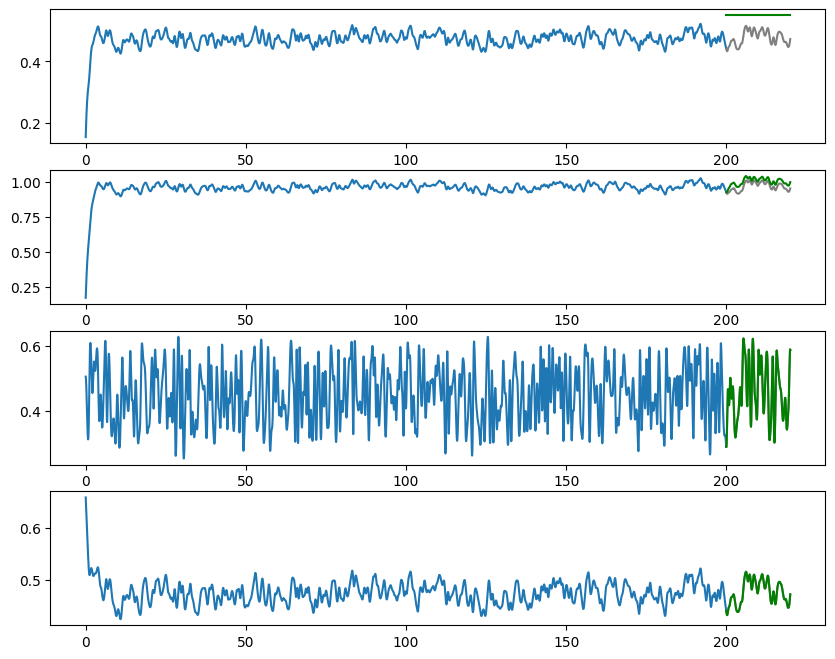

In [124]:
wc_multi_conf = WCMultiConf()
wc_multi_conf_data = wc_multi_conf.generate_data(
    num_train_obs=TRAIN_STEPS, num_forecast_obs=FORECAST_STEPS)

plot_cvr_data(wc_multi_conf_data)

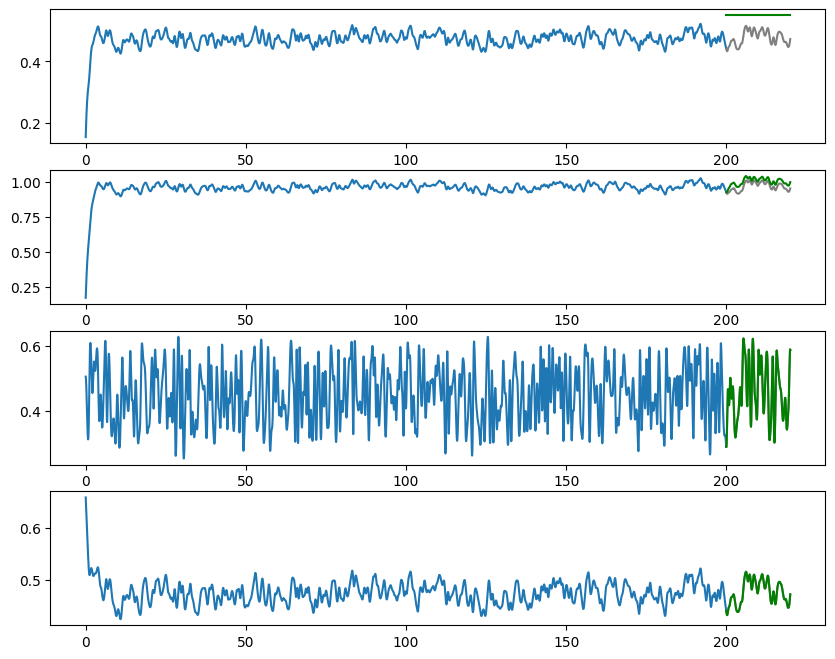

In [125]:
wc_downstream = WCDownstream()
wc_downstream_data = wc_downstream.generate_data(
    num_train_obs=TRAIN_STEPS, num_forecast_obs=FORECAST_STEPS)

plot_cvr_data(wc_multi_conf_data)

In [126]:
# @title Lotka Voltera Data Generators

LK_TIMESTEP = 0.02
LK_AMAX = 6
LK_AMIN = 3
LK_FMAX = 3.0
LK_FMIN = 2
LK_MAX_T = LK_TIMESTEP * MAX_NUM_STEPS
LK_RNG = np.random.default_rng(111)
LK_RATES = LK_RNG.random(DIM) + 10
LK_CAPS = LK_RNG.random(DIM) * 10 + 10


LK_MULTI_CONF_INTERV_CONST = 14.0


class LKMultiConf(ie.data_generators.DataGenerator):

    # Intervention signals
    interv_sig = lambda self, t: LK_MULTI_CONF_INTERV_CONST
    exog = randsig(
        max_T=LK_MAX_T, amax=LK_AMAX, amin=LK_AMIN,
        fmax=LK_FMAX, fmin=LK_FMIN, rng=np.random.default_rng(13)
    )

    def __init__(self):
        super().__init__(
            model_type=interfere.dynamics.LotkaVolteraSDE,
            model_params={
                "growth_rates": LK_RATES,
                "capacities": LK_CAPS,
                "interaction_mat": 0.5 * MULTI_CONF_ADJ,
                "sigma": 0.0
            },
            obs_intervention_type=interfere.SignalIntervention,
            obs_intervention_params={
                "intervened_idxs": [2],
                "signals": [self.exog]
            },
            do_intervention_type=interfere.SignalIntervention,
            do_intervention_params={
                "intervened_idxs": [0, 2],
                "signals": [self.interv_sig, self.exog]
            },
            initial_condition=LK_RNG.random((1,DIM)) * 10,
            timestep=LK_TIMESTEP,
        )


LK_DOWNSTREAM_INTERV_CONST = 14

class LKDownstream(ie.data_generators.DataGenerator):

    # Intervention signals
    interv_sig = lambda self, t: LK_DOWNSTREAM_INTERV_CONST
    exog = randsig(
        max_T=LK_MAX_T, amax=LK_AMAX, amin=LK_AMIN,
        fmax=LK_FMAX, fmin=LK_FMIN, rng=np.random.default_rng(21)
    )

    def __init__(self):
        super().__init__(
            model_type=interfere.dynamics.LotkaVolteraSDE,
            model_params={
                "growth_rates": LK_RATES,
                "capacities": LK_CAPS,
                "interaction_mat": 0.5 * DOWNSTREAM_ADJ,
                "sigma": 0.0,
            },
            obs_intervention_type=interfere.SignalIntervention,
            obs_intervention_params={
                "intervened_idxs": [2],
                "signals": [self.exog]
            },
            do_intervention_type=interfere.SignalIntervention,
            do_intervention_params={
                "intervened_idxs": [0, 2],
                "signals": [self.interv_sig, self.exog]
            },
            initial_condition=LK_RNG.random((1,DIM)) * 10,
            timestep=LK_TIMESTEP,
        )

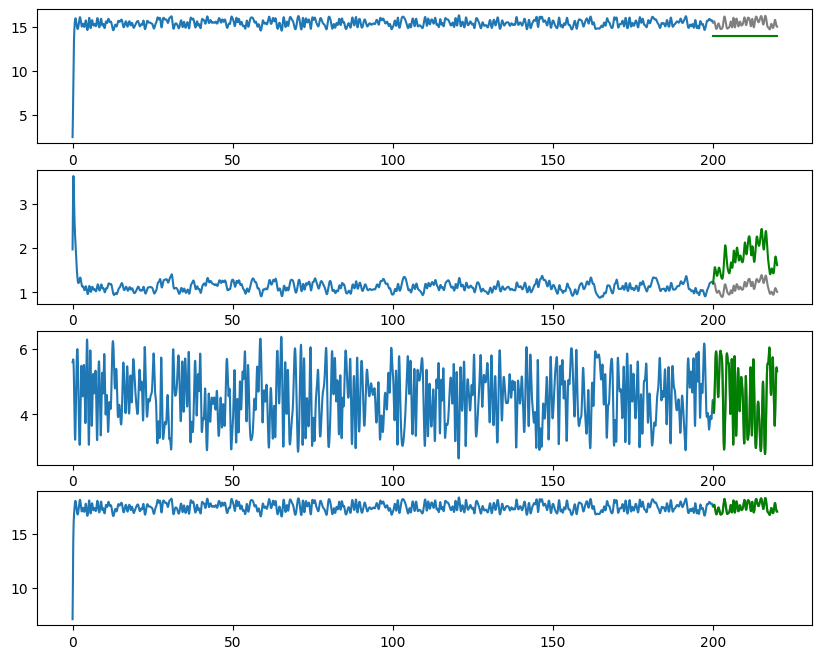

In [127]:
lk_multi_conf = LKMultiConf()
lk_multi_conf_data = lk_multi_conf.generate_data(
    num_train_obs=TRAIN_STEPS, num_forecast_obs=FORECAST_STEPS)

plot_cvr_data(lk_multi_conf_data)

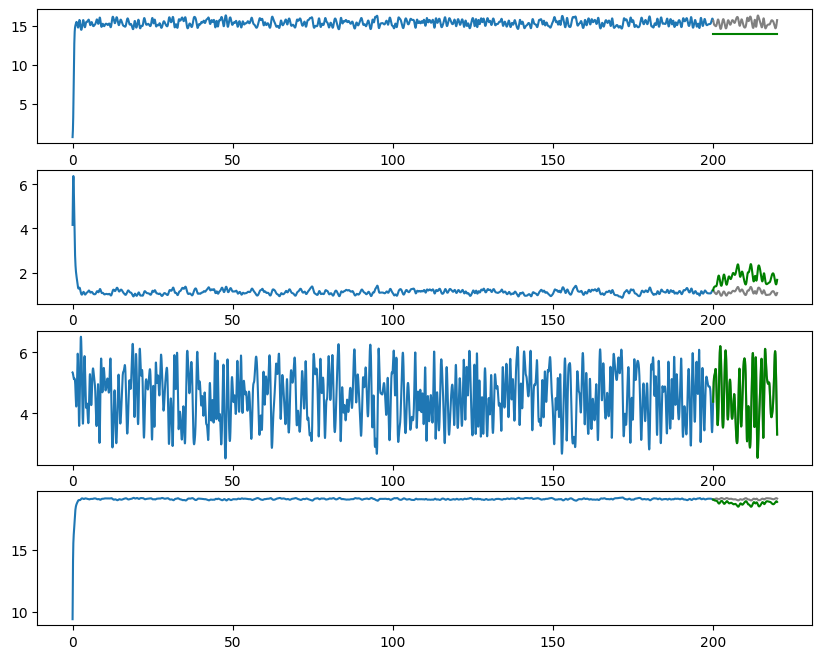

In [128]:
lk_downstream = LKDownstream()
lk_downstream_data = lk_downstream.generate_data(
    num_train_obs=TRAIN_STEPS, num_forecast_obs=FORECAST_STEPS)

plot_cvr_data(lk_downstream_data)

In [129]:
# @title CML Data Generators

CML_TIMESTEP = 1.0
CML_AMAX = 0.6
CML_AMIN = 0.4
CML_FMAX = 3.0
CML_FMIN = 0.2
CML_MAX_T = CML_TIMESTEP * MAX_NUM_STEPS


CML_MULTI_CONF_INIT_COND_RNG = np.random.default_rng(1)
CML_MULTI_CONF_INTERV_CONST = 0.55

class CMLMultiConf(ie.data_generators.DataGenerator):

    # Intervention signals
    interv_sig = lambda self, t: CML_MULTI_CONF_INTERV_CONST
    exog = randsig(
        max_T=CML_TIMESTEP * MAX_NUM_STEPS, amax=CML_AMAX, amin=CML_AMIN,
        fmax=CML_FMAX, fmin=CML_FMIN, rng=np.random.default_rng(11)
    )

    def __init__(self):
        super().__init__(
            model_type=interfere.dynamics.coupled_logistic_map,
            model_params={
                "logistic_param": 3.72,
                "eps": 0.75,
                "adjacency_matrix": MULTI_CONF_ADJ + np.eye(DIM),
            },
            obs_intervention_type=interfere.SignalIntervention,
            obs_intervention_params={
                "intervened_idxs": [2],
                "signals": [self.exog]
            },
            do_intervention_type=interfere.SignalIntervention,
            do_intervention_params={
                "intervened_idxs": [0, 2],
                "signals": [self.interv_sig, self.exog]
            },
            initial_condition=CML_MULTI_CONF_INIT_COND_RNG.random((1,DIM)),
            timestep=CML_TIMESTEP,
        )


CML_DOWNSTREAM_INIT_COND_RNG = np.random.default_rng(2)
CML_DOWNSTREAM_INTERV_CONST = 0.6

class CMLDownstream(ie.data_generators.DataGenerator):

    # Intervention signals
    interv_sig = lambda self, t: CML_DOWNSTREAM_INTERV_CONST
    exog = randsig(
        max_T=CML_TIMESTEP * MAX_NUM_STEPS, amax=CML_AMAX, amin=CML_AMIN,
        fmax=CML_FMAX, fmin=CML_FMIN, rng=np.random.default_rng(12)
    )

    def __init__(self):
        super().__init__(
            model_type=interfere.dynamics.coupled_logistic_map,
            model_params={
                "logistic_param": 3.72,
                "eps": 0.75,
                "adjacency_matrix": DOWNSTREAM_ADJ + np.eye(DIM),
            },
            obs_intervention_type=interfere.SignalIntervention,
            obs_intervention_params={
                "intervened_idxs": [2],
                "signals": [self.exog]
            },
            do_intervention_type=interfere.SignalIntervention,
            do_intervention_params={
                "intervened_idxs": [0, 2],
                "signals": [self.interv_sig, self.exog]
            },
            initial_condition=CML_MULTI_CONF_INIT_COND_RNG.random((1,DIM)),
            timestep=CML_TIMESTEP,
        )

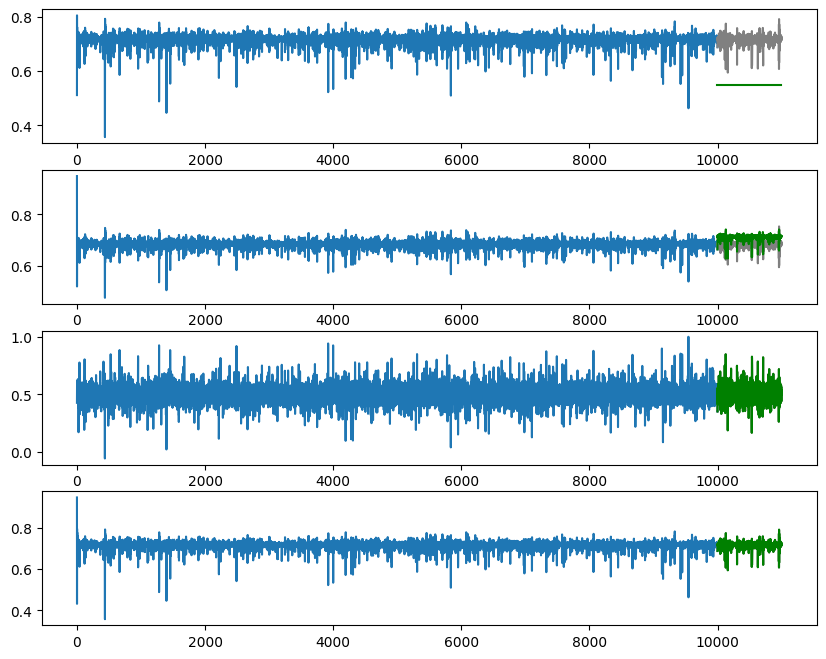

In [130]:
cml_multi_conf = CMLMultiConf()
cml_multi_conf_data = cml_multi_conf.generate_data(
    num_train_obs=TRAIN_STEPS, num_forecast_obs=FORECAST_STEPS)

plot_cvr_data(cml_multi_conf_data)

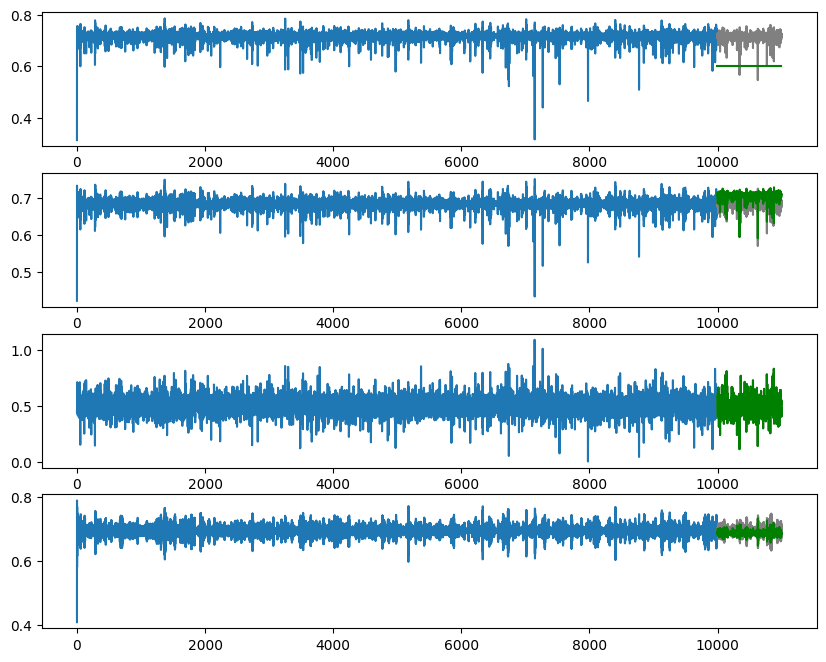

In [131]:
cml_downstream = CMLDownstream()
cml_downstream_data = cml_downstream.generate_data(
    num_train_obs=TRAIN_STEPS, num_forecast_obs=FORECAST_STEPS)

plot_cvr_data(cml_downstream_data)

[I 2025-01-31 21:59:59,740] A new study created in memory with name: SINDY(obs=105)
[I 2025-01-31 22:00:00,002] Trial 0 finished with value: 11.153419506950916 and parameters: {'optimizer__threshold': 0.18543613439758427, 'optimizer__alpha': 1.02460116081744e-05, 'discrete_time': True, 'feature_library': <class 'pysindy.feature_library.fourier_library.FourierLibrary'>, 'differentiation_method': {'kind': 'spline', 's': 0.5}}. Best is trial 0 with value: 11.153419506950916.
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
[I 2025-01-31 22:00:00,078] Trial 1 finished with value: 16.090455600226278 and parameters: {'optimizer__threshold': 0.029591305823442663, 'optimizer__alpha': 0.3143885242360601, 'd

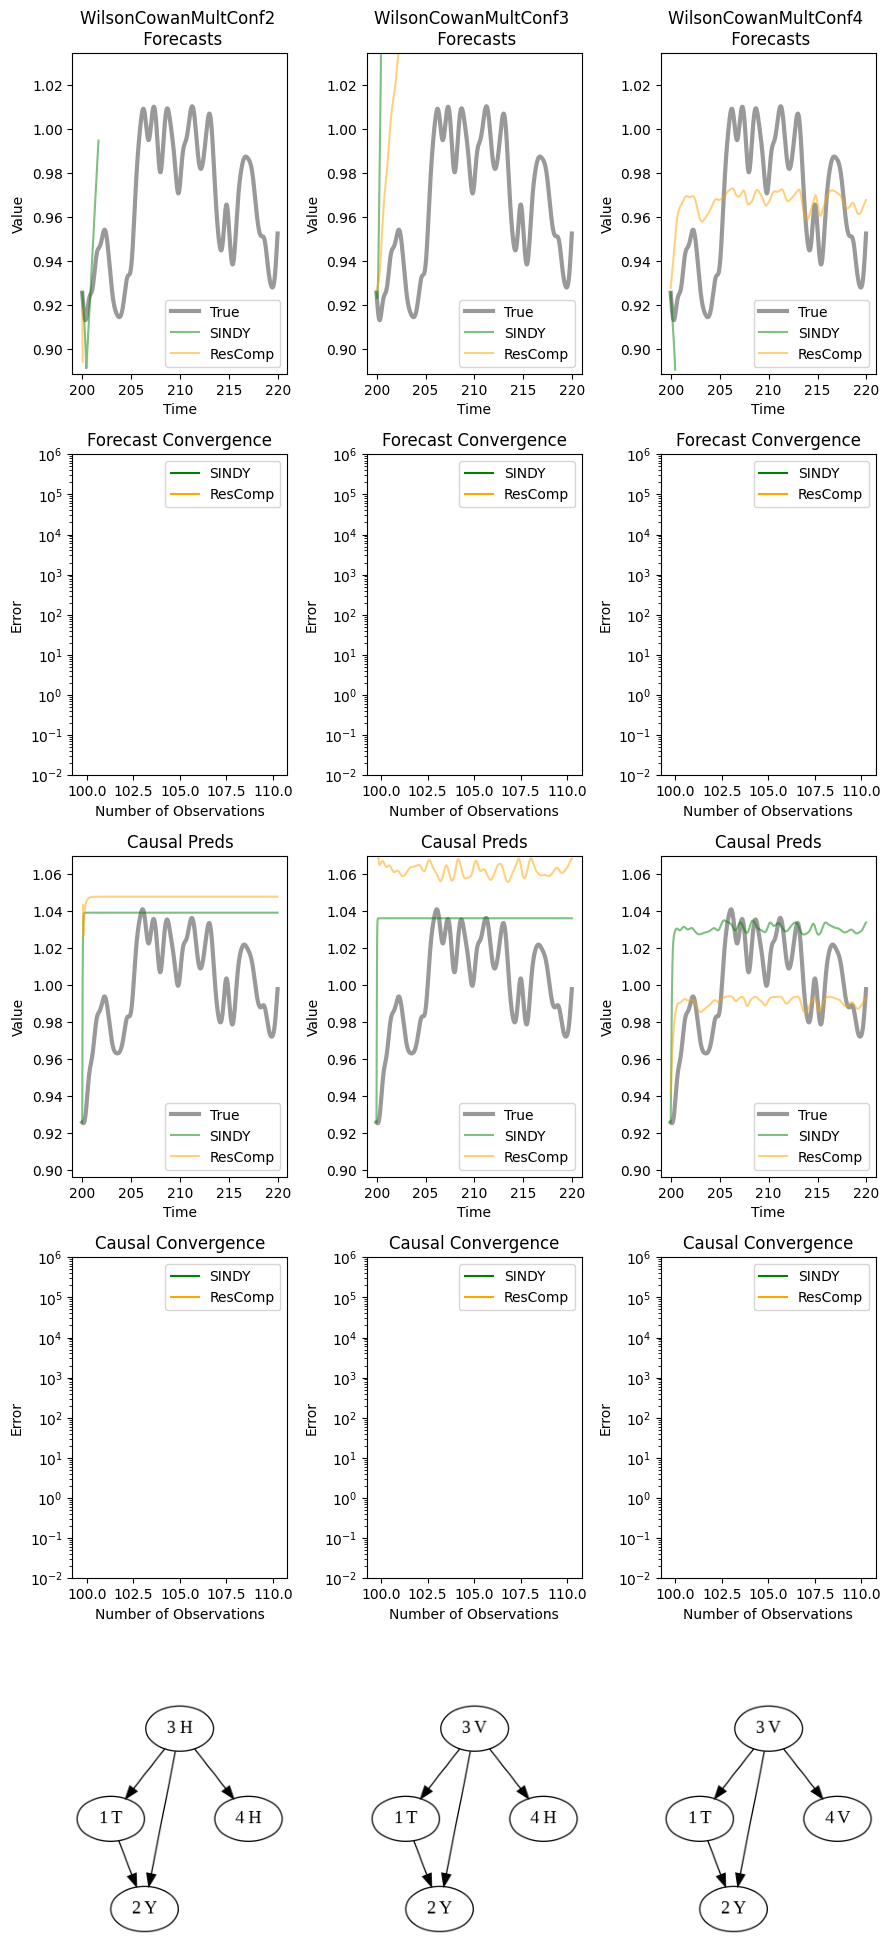

In [138]:
# @title Wilson Cowan Multi Confound
name = "WilsonCowanMultConf"
adj = MULTI_CONF_ADJ
data = wc_multi_conf_data

RESULTS[name] = run_conv_exp(
    data,
    name,
    min_obs_idx=1,
    max_obs_idx=3,
    target_var_idx=1,
)

with open(SAVE_FILE, "wb") as f:
    pickle.dump(RESULTS, f)

multi_dynamics_plot(
    data_dict=RESULTS[name],
    colors=COLORS,
    adjs=[adj for i in range(3)],
    node_label_lists=NODE_LABEL_LISTS
)



[I 2025-01-31 22:00:14,742] A new study created in memory with name: SINDY(obs=105)
[I 2025-01-31 22:00:14,825] Trial 0 finished with value: 24.77486804038469 and parameters: {'optimizer__threshold': 1.026773994684055, 'optimizer__alpha': 1.2397630708251346e-05, 'discrete_time': True, 'feature_library': <class 'pysindy.feature_library.polynomial_library.PolynomialLibrary'>, 'differentiation_method': {'kind': 'trend_filtered', 'order': 1, 'alpha': 0.1}}. Best is trial 0 with value: 24.77486804038469.
/usr/local/lib/python3.11/dist-packages/pysindy/optimizers/stlsq.py:191: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
[I 2025-01-31 22:00:14,895] Trial 1 finished with value: 19.688963387795916 and parameters: {'optimizer__threshold': 0.27460172273329136, 'optimizer__alpha': 0.0035981628826391356, 'discrete_time': False, 'feature_library': <class 'pysindy.feature_library.polynomial_library.PolynomialLibrary'>, 'differentiation_method': {'

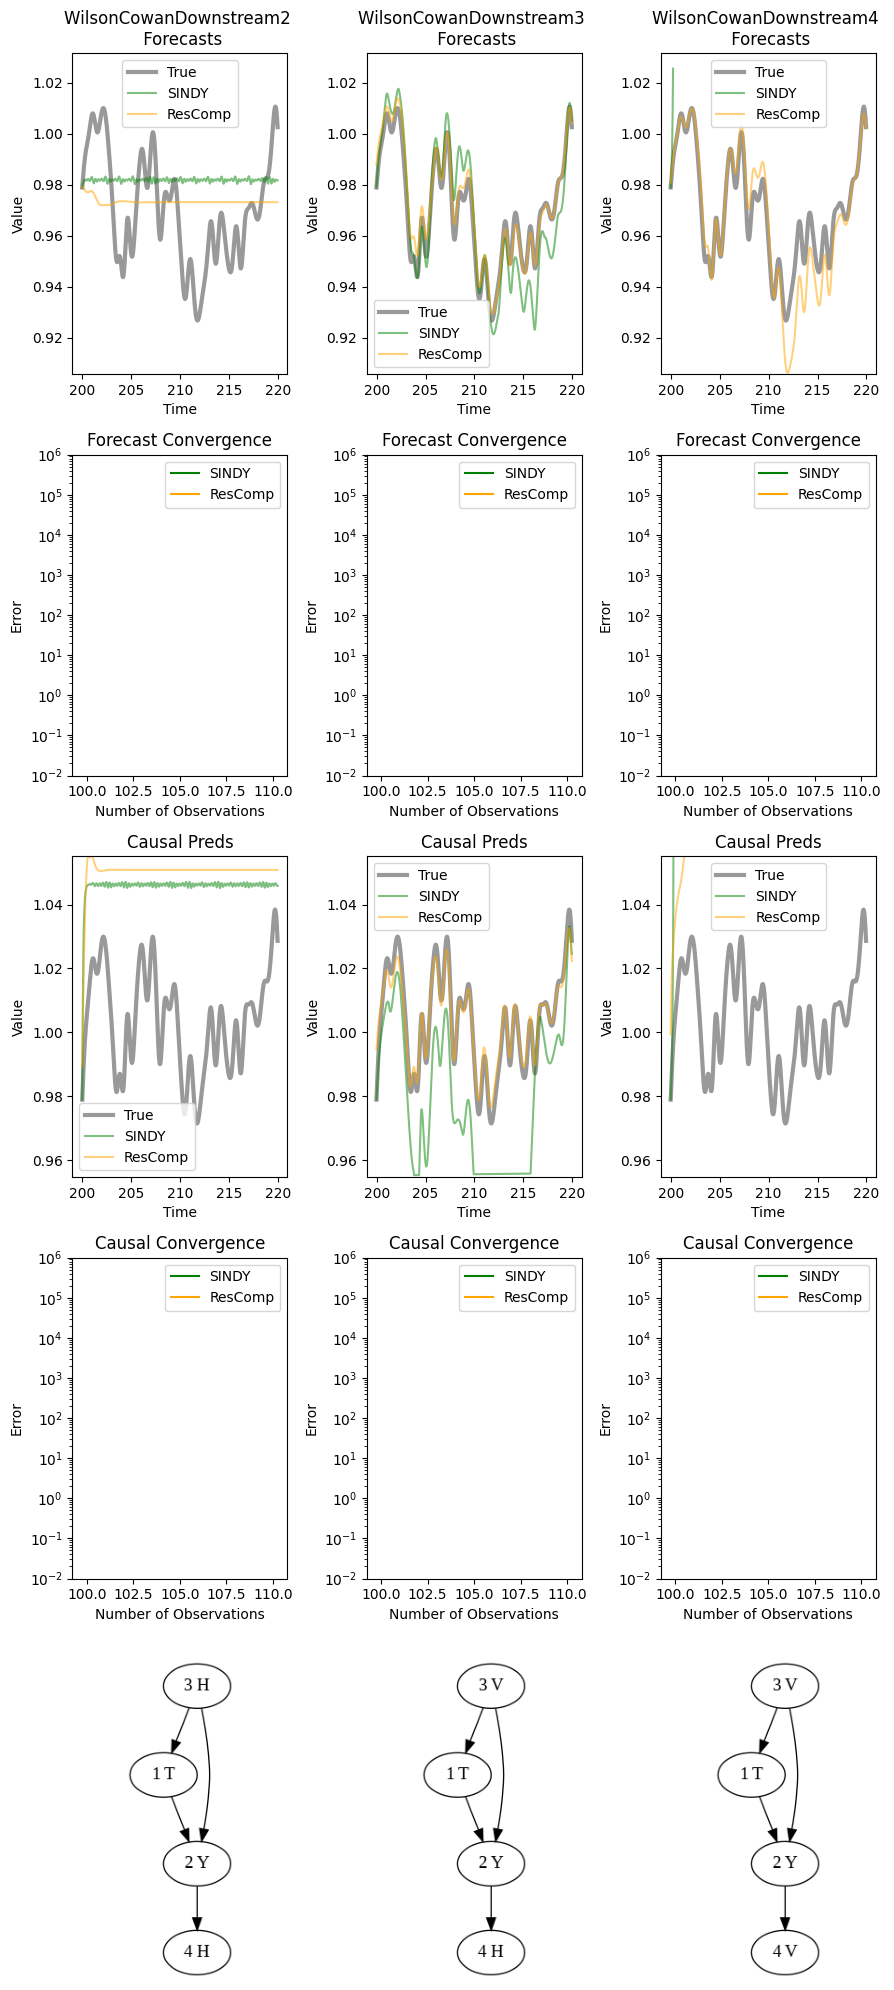

In [139]:
# @title Wilson Cowan Downstream
name = "WilsonCowanDownstream"
adj = DOWNSTREAM_ADJ
data = wc_downstream_data

RESULTS[name] = run_conv_exp(
    data,
    name,
    min_obs_idx=1,
    max_obs_idx=3,
    target_var_idx=1,
)

with open(SAVE_FILE, "wb") as f:
    pickle.dump(RESULTS, f)

multi_dynamics_plot(
    data_dict=RESULTS[name],
    colors=COLORS,
    adjs=[adj for i in range(3)],
    node_label_lists=NODE_LABEL_LISTS
)



In [ ]:
# @title Lotka Voltera Multi Conf
name = "LotkaVolteraMultiConf"
adj = MULTI_CONF_ADJ
data = lk_multi_conf

RESULTS[name] = run_conv_exp(
    data,
    name,
    min_obs_idx=1,
    max_obs_idx=3,
    target_var_idx=1,
)

with open(SAVE_FILE, "wb") as f:
    pickle.dump(RESULTS, f)

multi_dynamics_plot(
    data_dict=RESULTS[name],
    colors=COLORS,
    adjs=[adj for i in range(3)],
    node_label_lists=NODE_LABEL_LISTS
)



In [ ]:
# @title Lotka Voltera Downstream
name = "LotkaVolteraDownstream"
adj = DOWNSTREAM_ADJ
data = lk_downstream_data

RESULTS[name] = run_conv_exp(
    data,
    name,
    min_obs_idx=1,
    max_obs_idx=3,
    target_var_idx=1,
)

with open(SAVE_FILE, "wb") as f:
    pickle.dump(RESULTS, f)

multi_dynamics_plot(
    data_dict=RESULTS[name],
    colors=COLORS,
    adjs=[adj for i in range(3)],
    node_label_lists=NODE_LABEL_LISTS
)



In [ ]:
# @title CML Multi Conf
name = "CMLMultiConf"
adj = MULTI_CONF_ADJ
data = cml_multi_conf_data

RESULTS[name] = run_conv_exp(
    data,
    name,
    min_obs_idx=1,
    max_obs_idx=3,
    target_var_idx=1,
)

with open(SAVE_FILE, "wb") as f:
    pickle.dump(RESULTS, f)

multi_dynamics_plot(
    data_dict=RESULTS[name],
    colors=COLORS,
    adjs=[adj for i in range(3)],
    node_label_lists=NODE_LABEL_LISTS
)

In [ ]:
# @title CML Downstream
name = "CMLDownstream"
adj = DOWNSTREAM_ADJ
data = cml_downstream_data

RESULTS[name] = run_conv_exp(
    data,
    name,
    min_obs_idx=1,
    max_obs_idx=3,
    target_var_idx=1,
)

with open(SAVE_FILE, "wb") as f:
    pickle.dump(RESULTS, f)

multi_dynamics_plot(
    data_dict=RESULTS[name],
    colors=COLORS,
    adjs=[adj for i in range(3)],
    node_label_lists=NODE_LABEL_LISTS
)